# Time series example - window functions

Some example queries on time series data using aggregates and window functions.  Thanks to Divya Bhargov from VMware for this example notebook.

Data from https://data.cityofchicago.org/Transportation/Potholes-Patched/wqdh-9gek/data which is loaded from CSV format.

## Table of contents 

<a href="#setup">1. Connect to database</a>

<a href="#load_dataset">2. Load data</a>

<a href="#window">3. Window functions</a>

<a href="#mapping">4. Mapping for gap filling</a>

<a id="setup"></a>
## 1. Connect to database

In [24]:
%load_ext sql

# Greenplum Database 5.x on GCP (PM demo machine) - via tunnel
%sql postgresql://gpadmin@localhost:8000/madlib
        
# PostgreSQL local
#%sql postgresql://fmcquillan@localhost:5432/madlib
        
%sql SELECT version();

The sql extension is already loaded. To reload it, use:
  %reload_ext sql
1 rows affected.


version
"PostgreSQL 8.3.23 (Greenplum Database 5.18.0 build commit:6aec9959d367d46c6b4391eb9ffc82c735d20102) on x86_64-pc-linux-gnu, compiled by GCC gcc (GCC) 6.2.0, 64-bit compiled on Apr 3 2019 14:45:51"


<a id="load_dataset"></a>
## 2. Load data
Load from CSV.  You will need to change the path to the location of the CSV file.

In [47]:
%%sql
DROP TABLE IF EXISTS chicago_potholes_patched;
CREATE TABLE chicago_potholes_patched (
    id serial NOT NULL,
    address TEXT,
    request_date TIMESTAMP,
    completion_date TIMESTAMP,
    number_of_potholes_filled_on_block INTEGER,
    latitude FLOAT,
    longitude FLOAT,
    location TEXT
);

/* COPY chicago_potholes_patched(address, request_date, completion_date, number_of_potholes_filled_on_block, latitude, longitude, location) 
FROM '/Users/fmcquillan/Documents/Product/MADlib/Demos/Data/potholes_patched.csv' DELIMITER ',' CSV HEADER;*/

COPY chicago_potholes_patched(address, request_date, completion_date, number_of_potholes_filled_on_block, latitude, longitude, location) 
FROM '/home/gpadmin/data/potholes_patched.csv' DELIMITER ',' CSV HEADER;

Done.
Done.
65544 rows affected.


[]

In [48]:
%%sql
SELECT * FROM chicago_potholes_patched ORDER BY completion_date DESC LIMIT 10;

10 rows affected.


id,address,request_date,completion_date,number_of_potholes_filled_on_block,latitude,longitude,location
64544,4649 W FULLERTON AVE,2020-04-14 11:14:50,2020-04-21 15:25:34,4,41.924278082,-87.743872241,POINT (-87.743872241019 41.924278081659)
64878,2310 N KNOX AVE,2020-04-18 12:14:13,2020-04-21 15:24:44,12,41.922840944,-87.742654834,POINT (-87.742654834295 41.922840943632)
64459,2258 N KNOX AVE,2020-04-18 12:06:17,2020-04-21 15:23:55,15,41.922467136,-87.742610186,POINT (-87.742610186145 41.922467135904)
64807,3958 W FULLERTON AVE,2020-04-16 12:37:36,2020-04-21 15:22:08,2,41.924817886,-87.726093348,POINT (-87.726093348147 41.924817886186)
64812,2711 N PULASKI RD,2020-04-16 13:03:30,2020-04-21 15:20:16,2,41.930408431,-87.726595137,POINT (-87.726595137074 41.930408431011)
64844,4444 W DEMING PL,2020-04-14 11:07:56,2020-04-21 15:18:38,1,41.92754944,-87.738454216,POINT (-87.738454216115 41.927549439867)
64848,2536 N CENTRAL PARK AVE,2020-04-20 13:19:30,2020-04-21 15:16:36,19,41.927537543,-87.717339518,POINT (-87.717339517786 41.92753754297)
64545,5607 S KENWOOD AVE,2020-04-21 15:08:30,2020-04-21 15:12:51,4,41.793048858,-87.592978731,POINT (-87.592978730873 41.793048857693)
64765,8701 W FOSTER AVE,2020-04-16 18:46:19,2020-04-21 15:11:44,1,41.973190749,-87.844147025,POINT (-87.844147024715 41.97319074886)
64892,11521 S LA SALLE ST,2020-04-19 05:14:37,2020-04-21 14:57:33,15,41.684608279,-87.626219142,POINT (-87.626219142292 41.684608279405)


In [49]:
%%sql
select * from chicago_potholes_patched limit 10;

10 rows affected.


id,address,request_date,completion_date,number_of_potholes_filled_on_block,latitude,longitude,location
2,5505 W WINDSOR AVE,2019-04-24 14:06:04,2019-04-26 14:05:16,5,41.96306727,-87.765233061,POINT (-87.765233060697 41.963067269624)
4,400 E WALDRON DR,2019-07-23 10:00:36,2019-07-23 16:16:48,10,None,None,None
6,2101 S CANAL ST,2019-07-23 09:57:55,2019-07-23 09:58:51,12,41.854048592,-87.638463921,POINT (-87.638463920776 41.854048592448)
8,3651 W AINSLIE ST,2019-03-15 11:43:36,2019-04-29 14:37:02,10,41.970029,-87.7203,POINT (-87.7203 41.970029)
10,10346 S PULASKI RD,2019-02-28 16:42:32,2019-03-05 11:14:02,1,None,None,None
12,521 E 91ST PL,2019-06-13 10:18:24,2019-07-23 13:49:35,12,41.728137874,-87.610980602,POINT (-87.610980602161 41.7281378741)
14,801 E SOLIDARITY DR,2019-07-23 10:09:20,2019-07-23 10:10:10,20,41.866144383,-87.609999814,POINT (-87.609999814415 41.866144383387)
16,2500 W 36TH ST,2019-06-09 18:46:30,2019-07-23 10:46:44,48,41.828545615,-87.687820304,POINT (-87.687820304125 41.828545615092)
18,300 W CERMAK RD,2019-07-21 18:26:09,2019-07-23 15:06:49,18,41.85290813,-87.634936965,POINT (-87.634936964669 41.852908130256)
20,328 N DESPLAINES ST,2019-07-22 10:05:41,2019-07-23 09:54:46,10,41.887721193,-87.644343544,POINT (-87.644343543685 41.88772119348)


### Transform to year - month format

In [50]:
%%sql

DROP TABLE IF EXISTS temp_total_potholes_patched;

CREATE TABLE temp_total_potholes_patched(
    completion_year INTEGER,
    completion_month INTEGER,
    total_potholes_patched INTEGER
);

INSERT INTO temp_total_potholes_patched 
 SELECT date_part('year', completion_date) AS completion_year,
   date_part('month', completion_date) AS completion_month,
   sum(number_of_potholes_filled_on_block) AS total_potholes_patched
   FROM chicago_potholes_patched
   GROUP BY completion_year, completion_month;

SELECT * FROM temp_total_potholes_patched order by completion_year, completion_month;

Done.
Done.
22 rows affected.
22 rows affected.


completion_year,completion_month,total_potholes_patched
2018,7,25221
2018,8,21251
2018,9,13865
2018,10,15853
2018,11,13078
2018,12,12287
2019,1,32819
2019,2,78509
2019,3,135763
2019,4,106023


<a id="window"></a>
## 3. Window functions

### Potholes patched every month, compared to average potholes patched for the year

In [51]:
%%sql
SELECT completion_year, completion_month, total_potholes_patched,
avg(total_potholes_patched) OVER (PARTITION BY completion_year) AS average_for_year 
FROM temp_total_potholes_patched
ORDER BY completion_year, completion_month;

22 rows affected.


completion_year,completion_month,total_potholes_patched,average_for_year
2018,7,25221,16925.8333333333
2018,8,21251,16925.8333333333
2018,9,13865,16925.8333333333
2018,10,15853,16925.8333333333
2018,11,13078,16925.8333333333
2018,12,12287,16925.8333333333
2019,1,32819,45167.5833333333
2019,2,78509,45167.5833333333
2019,3,135763,45167.5833333333
2019,4,106023,45167.5833333333


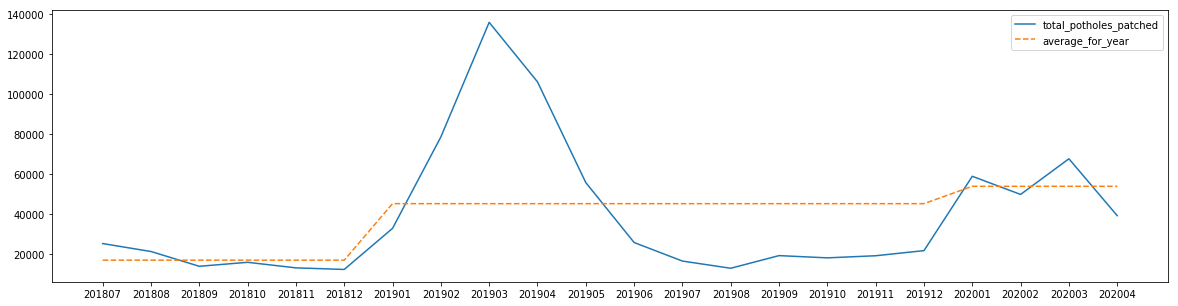

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = _.DataFrame()

df['date'] = df.completion_year.map("{:04}".format) + df.completion_month.map("{:02}".format)

plt.figure(figsize=(20,5))

plt.plot(df.date,df.total_potholes_patched, linestyle='solid');
plt.plot(df.date,df.average_for_year, linestyle='dashed');
plt.legend();

### Potholes patched every month, compared to previous month

In [53]:
%%sql
SELECT completion_year, completion_month, total_potholes_patched,
lag(total_potholes_patched, 1) OVER (ORDER BY completion_year, completion_month) AS potholes_patched_last_month
FROM temp_total_potholes_patched
ORDER BY completion_year, completion_month;

22 rows affected.


completion_year,completion_month,total_potholes_patched,potholes_patched_last_month
2018,7,25221,None
2018,8,21251,25221
2018,9,13865,21251
2018,10,15853,13865
2018,11,13078,15853
2018,12,12287,13078
2019,1,32819,12287
2019,2,78509,32819
2019,3,135763,78509
2019,4,106023,135763


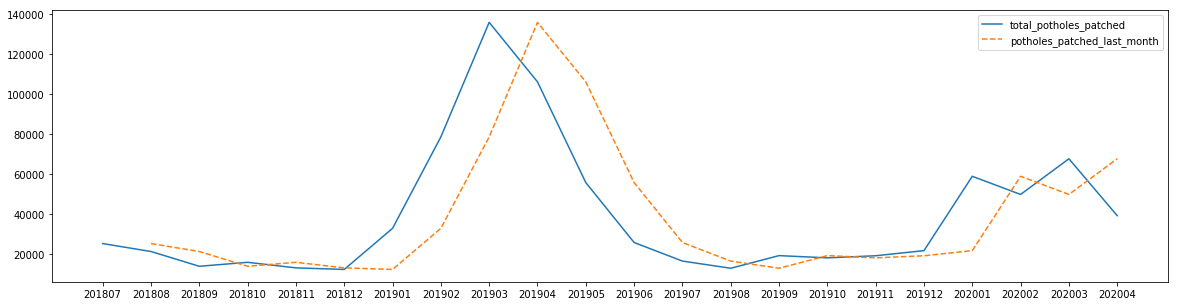

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = _.DataFrame()

df['date'] = df.completion_year.map("{:04}".format) + df.completion_month.map("{:02}".format)

plt.figure(figsize=(20,5))

plt.plot(df.date,df.total_potholes_patched, linestyle='solid');
plt.plot(df.date,df.potholes_patched_last_month, linestyle='dashed');
plt.legend();

### Accumulation - Total potholes patched to date

In [55]:
%%sql
select completion_year, completion_month, total_potholes_patched,
sum(total_potholes_patched) over (order by completion_year, completion_month) as total_potholes_patched_to_date
From temp_total_potholes_patched
order by completion_year, completion_month;

22 rows affected.


completion_year,completion_month,total_potholes_patched,total_potholes_patched_to_date
2018,7,25221,25221
2018,8,21251,46472
2018,9,13865,60337
2018,10,15853,76190
2018,11,13078,89268
2018,12,12287,101555
2019,1,32819,134374
2019,2,78509,212883
2019,3,135763,348646
2019,4,106023,454669


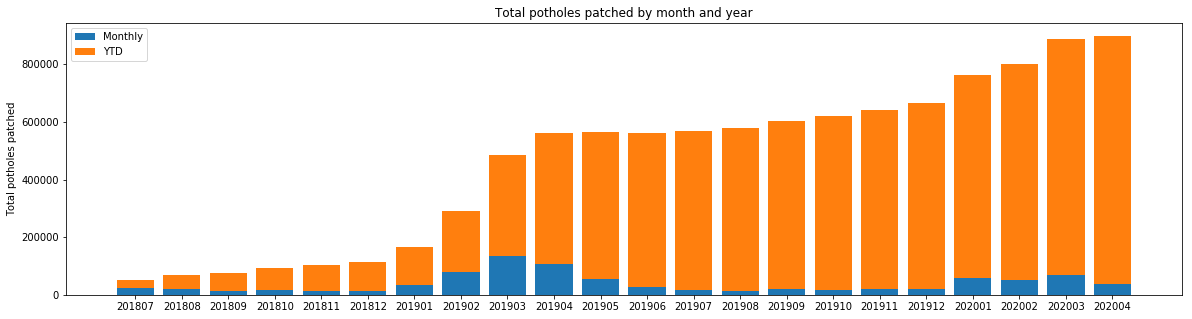

In [56]:
import numpy as np
import matplotlib.pyplot as plt

df = _.DataFrame()

df['date'] = df.completion_year.map("{:04}".format) + df.completion_month.map("{:02}".format)


plt.figure(figsize=(20,5))

p1 = plt.bar(df.date, df.total_potholes_patched)
p2 = plt.bar(df.date, df.total_potholes_patched_to_date,
             bottom=df.total_potholes_patched)


plt.ylabel('Total potholes patched');
plt.title('Total potholes patched by month and year');
plt.legend((p1[0], p2[0]), ('Monthly', 'YTD'));

plt.show();

### Rank - Top 3 months of 2019

In [57]:
%%sql
SELECT * FROM (
                 SELECT completion_year,
                        completion_month,
                        total_potholes_patched,
                        rank() OVER (PARTITION BY completion_year 
                                     ORDER BY total_potholes_patched desc) AS rank
                 FROM temp_total_potholes_patched
                 ORDER BY completion_year, completion_month
) AS ranked_records
WHERE rank <= 3
AND completion_year = 2019;

3 rows affected.


completion_year,completion_month,total_potholes_patched,rank
2019,3,135763,1
2019,4,106023,2
2019,2,78509,3


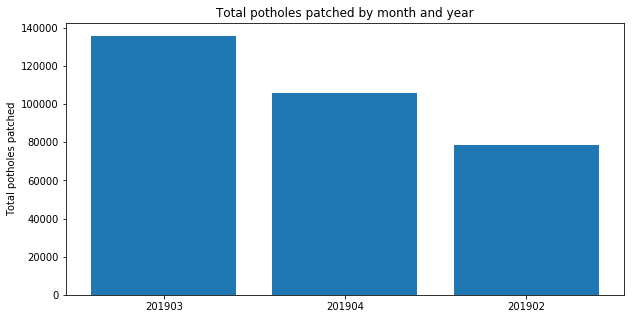

In [58]:
import numpy as np
import matplotlib.pyplot as plt

df = _.DataFrame()

df['date'] = df.completion_year.map("{:04}".format) + df.completion_month.map("{:02}".format)


plt.figure(figsize=(10,5))

p1 = plt.bar(df.date, df.total_potholes_patched)


plt.ylabel('Total potholes patched');
plt.title('Total potholes patched by month and year');

plt.show();

<a id="mapping"></a>
## 4. Mapping

In [59]:
%%sql
SELECT completion_date, interval_bound(completion_date, '5 minutes')
FROM chicago_potholes_patched LIMIT 10;

10 rows affected.


completion_date,interval_bound
2019-04-26 14:05:16,2019-04-26 14:05:00
2019-07-23 16:16:48,2019-07-23 16:15:00
2019-07-23 09:58:51,2019-07-23 09:55:00
2019-04-29 14:37:02,2019-04-29 14:35:00
2019-03-05 11:14:02,2019-03-05 11:10:00
2019-07-23 13:49:35,2019-07-23 13:45:00
2019-07-23 10:10:10,2019-07-23 10:10:00
2019-07-23 10:46:44,2019-07-23 10:45:00
2019-07-23 15:06:49,2019-07-23 15:05:00
2019-07-23 09:54:46,2019-07-23 09:50:00


### Gap filling
Notice gap in days

In [60]:
%%sql

SELECT interval_bound(completion_date, '1 day') as date, sum(number_of_potholes_filled_on_block)
FROM chicago_potholes_patched 
WHERE  completion_date >= '2019-06-01'
AND    completion_date <= '2019-06-15'
GROUP BY date ORDER BY date;

10 rows affected.


date,sum
2019-06-03 00:00:00,1605
2019-06-04 00:00:00,2206
2019-06-05 00:00:00,1814
2019-06-06 00:00:00,1365
2019-06-07 00:00:00,1973
2019-06-10 00:00:00,514
2019-06-11 00:00:00,1408
2019-06-12 00:00:00,1714
2019-06-13 00:00:00,1550
2019-06-14 00:00:00,1415


Generate dates you want (with no gaps)

In [61]:
%%sql

SELECT date FROM generate_series('2019-06-01'::date,'2019-06-15','1 day') date


15 rows affected.


date
2019-06-01 00:00:00+00:00
2019-06-02 00:00:00+00:00
2019-06-03 00:00:00+00:00
2019-06-04 00:00:00+00:00
2019-06-05 00:00:00+00:00
2019-06-06 00:00:00+00:00
2019-06-07 00:00:00+00:00
2019-06-08 00:00:00+00:00
2019-06-09 00:00:00+00:00
2019-06-10 00:00:00+00:00


Gap filling query

In [62]:
%%sql
WITH
 bounded AS (
   SELECT interval_bound(completion_date, '1 day') AS date,number_of_potholes_filled_on_block
   FROM chicago_potholes_patched
   WHERE completion_date >= '2019-06-01' AND completion_date <= '2019-06-15'
 ),
 dense AS (
   SELECT slice AS date
   FROM generate_series('2019-06-01'::date,'2019-06-15','1 day') s(slice)
 )
SELECT date, sum(coalesce(number_of_potholes_filled_on_block,0))
FROM bounded NATURAL RIGHT JOIN dense
GROUP BY date ORDER BY date;

15 rows affected.


date,sum
2019-06-01 00:00:00+00:00,0
2019-06-02 00:00:00+00:00,0
2019-06-03 00:00:00+00:00,1605
2019-06-04 00:00:00+00:00,2206
2019-06-05 00:00:00+00:00,1814
2019-06-06 00:00:00+00:00,1365
2019-06-07 00:00:00+00:00,1973
2019-06-08 00:00:00+00:00,0
2019-06-09 00:00:00+00:00,0
2019-06-10 00:00:00+00:00,514
